## Google Driveマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/suzume
%cd /content

/content/drive/MyDrive/Colab Notebooks/suzume
/content


# SAM2のセットアップ

In [60]:
!git clone https://github.com/facebookresearch/sam2.git

fatal: destination path 'sam2' already exists and is not an empty directory.


In [8]:
# !pip install ./sam2 --target /content/drive/MyDrive/Colab\ Notebooks/suzume/lib
!pip install ./sam2

Processing ./sam2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.4 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=sam_2-1.0-cp312-cp312-linux_x86_64.whl size=501911 sha256=7d4235cd99f2c028cdde165027c30a398a3aa55d6f64ea5cc398e3c410afe353
  Stored in directory: /tmp/pip-ephem-wheel-cache-79upgwsx/wheels/9e/fa/17/14aaeb20d3ca07c58ee93742054d4479f89c243063ce0b61b9
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=df7d2bfc1c4a76caa6df55d2a25dd6953016a82f6ee0fc9d0786e1d9085f6e46
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built SAM-2 iopath


download checkpoint

In [61]:
!cd ./sam2/checkpoints && \
sh ./download_ckpts.sh

/usr/bin/wget
--2025-10-17 15:33:04--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.111, 13.35.37.84, 13.35.37.123, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt.1’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   198MB/s    in 0.8s    

2025-10-17 15:33:05 (198 MB/s) - ‘sam2.1_hiera_tiny.pt.1’ saved [156008466/156008466]

--2025-10-17 15:33:05--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.111, 13.35.37.84, 13.35.37.123, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184416285 

# Yolo5のセットアップ

In [3]:
# !pip install ultralytics --target /content/drive/MyDrive/Colab\ Notebooks/suzume/lib
!pip install ultralytics

## 関数

In [3]:
#import sys
#sys.path.append("/content/drive/MyDrive/Colab Notebooks/suzume/lib")

In [4]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2_video_predictor
from PIL import Image

def show_mask(mask, ax, obj_id=None, random_color=False):
    """
    SAM2の実行結果のセグメンテーションをマスクとして描画する。

    Args:
        mask (numpy.ndarray): 実行結果のセグメンテーション
        ax (matplotlib.axes._axes.Axes): matplotlibのAxis
        obj_id (int): オブジェクトID
        random_color (bool): マスクの色をランダムにするかどうか
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    """
    指定した座標に星を描画する。
    labelsがPositiveの場合は緑、Negativeの場合は赤。

    Args:
        coords (numpy.ndarray): 指定した座標
        labels (numpy.ndarray): Positive or Negative
        ax (matplotlib.axes._axes.Axes): matplotlibのAxis
        marker_size (int, optional): マーカーのサイズ
    """
    print(type(coords))
    print(type(labels))
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    """
    指定された矩形を描画する

    Args:
        box (numoy.ndarray): 矩形の座標情報（x_min, y_min, x_max, y_max）
        ax (matplotlib.axes._axes.Axes): matplotlibのAxis
    """
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


## Videoロード

In [5]:
video_path = '/content/drive/MyDrive/Colab Notebooks/suzume/sampledata/suzume_sample.mp4'

In [6]:
import cv2

# Create a video capture object
cap = cv2.VideoCapture(video_path)

# Check if the video file was opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    print("Video file opened successfully.")
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret or len(frames) >= 100:
            break
        frames.append(frame)

    cap.release()
    print(f"Total number of frames extracted: {len(frames)}")

Video file opened successfully.
Total number of frames extracted: 100


## 動画　→　画像変換

In [7]:
import os
import cv2

# Define the directory to save the frames
video_dir = 'sample_video'

# Create the output directory if it doesn't exist
if not os.path.exists(video_dir):
    os.makedirs(video_dir)
    print(f"Directory '{video_dir}' created.")
else:
    print(f"Directory '{video_dir}' already exists.")

frame_names = []
# Save each frame as a JPEG image
for i, frame in enumerate(frames):
    # Define the filename for each frame
    frame_name = f'{i:05d}.jpg'
    frame_names.append(f'{i:05d}.jpg')
    path = os.path.join(video_dir, f'{i:05d}.jpg') # Use zero-padding for consistent filenames

    # Save the frame as a JPEG image
    cv2.imwrite(path, frame)

print(f"Saved {len(frames)} frames to '{video_dir}'.")

Directory 'sample_video' already exists.
Saved 100 frames to 'sample_video'.


## Faster -R-CNNでの鳥抽出

In [8]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np

# Determine the device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Move the model to the device
model.to(device)

# Set the model to evaluation mode
model.eval()

# COCO dataset class labels
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Get the class ID for 'bird'
bird_class_id = 16  # COCO_CLASSES.index('bird')
print(f"Bird class ID: {bird_class_id}")

# Perform detection on each frame
faster_rcnn_bird_boxes = []

# Set a confidence threshold for detections
confidence_threshold = 0.8 # Adjust this value as needed

with torch.no_grad(): # No need to calculate gradients for inference
    for i, frame in enumerate(frames):
        # Convert the frame from OpenCV BGR format to RGB and then to a PyTorch tensor
        # Permute the dimensions from (H, W, C) to (C, H, W) and normalize to [0, 1]
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_tensor = torch.from_numpy(frame_rgb).permute(2, 0, 1).float() / 255.0
        frame_tensor = frame_tensor.to(device)

        # Add a batch dimension
        frame_tensor = frame_tensor.unsqueeze(0)

        # Get predictions
        predictions = model(frame_tensor)

        # Filter predictions for 'bird' class with high confidence
        boxes = predictions[0]['boxes']
        labels = predictions[0]['labels']
        scores = predictions[0]['scores']

        bird_detections = boxes[
            (labels == bird_class_id) & (scores > confidence_threshold)
        ]

        # Store the bounding boxes for the current frame
        faster_rcnn_bird_boxes.append(bird_detections.cpu().tolist())

print(f"Faster R-CNN detection complete for {len(frames)} frames.")

Using device: cuda
Bird class ID: 16
Faster R-CNN detection complete for 100 frames.


In [9]:
yolo_result_dir = 'detection_results'

# Create the output directory if it doesn't exist
if not os.path.exists(yolo_result_dir):
    os.makedirs(yolo_result_dir)
    print(f"Directory '{yolo_result_dir}' created.")
else:
    print(f"Directory '{yolo_result_dir}' already exists.")

# セグメンテーション結果を保存
plt.close("all")
for out_frame_idx in range(len(frame_names)):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.axis('off')
    plt.tight_layout(pad=0)

    # cv2はデフォルトがBGRのため、RGBに変換してから出力する
    image = cv2.imread(os.path.join(video_dir, frame_names[out_frame_idx]))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # マスクの描画
    for bbox in faster_rcnn_bird_boxes[out_frame_idx]:
        show_box(bbox, plt.gca())

    # マスク済みの画像を出力する
    file_name = os.path.basename(frame_names[out_frame_idx])
    plt.savefig(os.path.join(yolo_result_dir, file_name))
    plt.close()

Directory 'detection_results' already exists.


## sam2によるセグメンテーション

In [10]:
import torch
from sam2.build_sam import build_sam2_video_predictor

# Determine the device to use
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

checkpoint = "./sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

print("SAM2 model loaded successfully.")

Using device: cuda
SAM2 model loaded successfully.


In [11]:
def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1 (list): [x_min, y_min, x_max, y_max]
        box2 (list): [x_min, y_min, x_max, y_max]

    Returns:
        float: The IoU value.
    """
    # Determine the (x, y)-coordinates of the intersection rectangle
    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])

    # Compute the area of intersection rectangle
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # Compute the area of both the prediction and ground-truth rectangles
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou

def add_new_bbox(inference_state, frame_idx, obj_id, bbox):
    # Calculate the center point of the non-overlapping box
    center_x = (bbox[0] + bbox[2]) / 2.0
    center_y = (bbox[1] + bbox[3]) / 2.0
    points = np.array([[center_x, center_y]], dtype=np.float32)
    labels = np.array([1], np.int32)

    # Add the new object using the center point
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=frame_idx,
        obj_id=obj_id,
        points=points,
        labels=labels,
    )
    return out_obj_ids, out_mask_logits

def add_obj_if_not_overlapping(current_frame_idx, faster_rcnn_boxes, predictor, inference_state, current_segments):
    """
    Add new objects to the SAM2 inference state based on Faster R-CNN detections
    that do not overlap with previous segmentation results.

    Args:
        current_frame_idx (int): The index of the current frame.
        faster_rcnn_boxes (list): A list of bounding boxes from Faster R-CNN.
        predictor: The SAM2 video predictor object.
        inference_state (dict): The current SAM2 inference state.
        current_segments (dict): Segmentation results from the previous frame.

    Returns:
        dict: The updated SAM2 inference state.
    """
    iou_threshold = 0.5  # Define IoU threshold
    current_obj_ids = list(inference_state['obj_ids'])
    next_obj_id = max(current_obj_ids) + 1 if current_obj_ids else 0

    added_objs = {}

    print("================================")

    for rcnn_box_i, rcnn_box in enumerate(faster_rcnn_boxes):
        is_overlapping = False
        if current_segments:
            print("current_segments", len(current_segments), current_segments)
            for obj_id, mask in current_segments.items():
                # Convert mask to bounding box for IoU calculation
                # Find the coordinates of the true values in the mask
                coords = np.where(mask)
                if coords[0].size > 0:
                    y_min_mask, y_max_mask = np.min(coords[1]), np.max(coords[1])
                    x_min_mask, x_max_mask = np.min(coords[2]), np.max(coords[2])
                    mask_box = [x_min_mask, y_min_mask, x_max_mask, y_max_mask]

                    iou = calculate_iou(rcnn_box, mask_box)
                    print()
                    print(f"frame:{current_frame_idx}, obj_id:{obj_id}, rcnn_box_i:{rcnn_box_i}")
                    print("rcnn", rcnn_box)
                    print("mask", mask_box)
                    print(iou)
                    if iou > iou_threshold:
                        is_overlapping = True
                        break  # Found an overlapping segment, move to the next R-CNN box

        if not is_overlapping:
            _, _ = add_new_bbox(inference_state, current_frame_idx, next_obj_id, bbox)
            # Calculate the center point of the non-overlapping box
            center_x = (rcnn_box[0] + rcnn_box[2]) / 2.0
            center_y = (rcnn_box[1] + rcnn_box[3]) / 2.0
            points = np.array([[center_x, center_y]], dtype=np.float32)
            labels = np.array([1], np.int32)

            # Add the new object using the center point
            _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                inference_state=inference_state,
                frame_idx=current_frame_idx,
                obj_id=next_obj_id,
                points=points,
                labels=labels,
            )

            # Increment the next object ID
            next_obj_id += 1

            added_objs = {
                out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }
            print(f"Added {len(added_objs)} objects to frame {current_frame_idx} added_obj_ids {out_obj_ids}.")


    return added_objs


def is_overlapping(box, segments):
    iou_threshold = 0.5  # Define IoU threshold
    for obj_id, mask in segments.items():
        # Convert mask to bounding box for IoU calculation
        # Find the coordinates of the true values in the mask
        coords = np.where(mask)
        if coords[0].size > 0:
            y_min_mask, y_max_mask = np.min(coords[1]), np.max(coords[1])
            x_min_mask, x_max_mask = np.min(coords[2]), np.max(coords[2])
            mask_box = [x_min_mask, y_min_mask, x_max_mask, y_max_mask]

            iou = calculate_iou(rcnn_box, mask_box)
            if iou > iou_threshold:
                return True
    return False


def out_obj2segment(out_obj_ids, out_mask_logits):
    current_segments = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
    return current_segments


def track_object(initial_frame_idx:int, center_x:int, center_y:int, obj_id:int):
    object_segments = {}

    # Initialize the inference state with the first frame
    inference_state = predictor.init_state(video_dir)

    points = np.array([[center_x, center_y]], dtype=np.float32)
    labels = np.array([1], np.int32)

    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=initial_frame_idx,
        obj_id=next_obj_id,
        points=points,
        labels=labels,
    )
    object_segments[initial_frame_idx] = out_obj2segment(out_obj_ids, out_mask_logits)

    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        if len(out_obj_ids) == 0:
            break
        object_segments[out_frame_idx] = out_obj2segment(out_obj_ids, out_mask_logits)

    return object_segments


def merge_segments(object_segments, new_object_segments):
    for i, segments in new_object_segments.items():
        object_segments[i] |= segments
    return object_segments

In [12]:
max_frame_id = len(frame_names)

object_segments = {i:{} for i in range(max_frame_id)}
next_obj_id = 0
for frame_idx in range(max_frame_id):
    print(f"Processing frame {frame_idx}")
    for rcnn_box in faster_rcnn_bird_boxes[frame_idx]:
        if is_overlapping(rcnn_box, object_segments[frame_idx]):
            continue

        center_x = (rcnn_box[0] + rcnn_box[2]) / 2.0
        center_y = (rcnn_box[1] + rcnn_box[3]) / 2.0
        new_object_segments = track_object(frame_idx, center_x, center_y, next_obj_id)
        object_segments = merge_segments(object_segments, new_object_segments)

        next_obj_id += 1

Processing frame 0


propagate in video: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Processing frame 1
Processing frame 2
Processing frame 3
Processing frame 4
Processing frame 5
Processing frame 6
Processing frame 7
Processing frame 8
Processing frame 9
Processing frame 10
Processing frame 11
Processing frame 12
Processing frame 13
Processing frame 14
Processing frame 15
Processing frame 16
Processing frame 17
Processing frame 18
Processing frame 19
Processing frame 20
Processing frame 21
Processing frame 22
Processing frame 23
Processing frame 24
Processing frame 25
Processing frame 26
Processing frame 27
Processing frame 28
Processing frame 29
Processing frame 30
Processing frame 31
Processing frame 32


propagate in video: 100%|██████████| 68/68 [01:03<00:00,  1.06it/s]


Processing frame 33
Processing frame 34
Processing frame 35
Processing frame 36
Processing frame 37
Processing frame 38
Processing frame 39
Processing frame 40
Processing frame 41
Processing frame 42
Processing frame 43
Processing frame 44
Processing frame 45
Processing frame 46
Processing frame 47
Processing frame 48
Processing frame 49
Processing frame 50
Processing frame 51
Processing frame 52
Processing frame 53
Processing frame 54
Processing frame 55
Processing frame 56
Processing frame 57
Processing frame 58


propagate in video: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]


Processing frame 59
Processing frame 60
Processing frame 61
Processing frame 62
Processing frame 63
Processing frame 64
Processing frame 65
Processing frame 66
Processing frame 67
Processing frame 68
Processing frame 69


propagate in video: 100%|██████████| 31/31 [00:28<00:00,  1.08it/s]


Processing frame 70
Processing frame 71
Processing frame 72
Processing frame 73
Processing frame 74
Processing frame 75
Processing frame 76
Processing frame 77
Processing frame 78
Processing frame 79
Processing frame 80
Processing frame 81
Processing frame 82
Processing frame 83
Processing frame 84
Processing frame 85
Processing frame 86
Processing frame 87
Processing frame 88
Processing frame 89
Processing frame 90
Processing frame 91
Processing frame 92
Processing frame 93
Processing frame 94
Processing frame 95
Processing frame 96
Processing frame 97
Processing frame 98
Processing frame 99


In [13]:
video_segments = object_segments

In [ ]:
result_dir = 'result'

# Create the output directory if it doesn't exist
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
    print(f"Directory '{result_dir}' created.")
else:
    print(f"Directory '{result_dir}' already exists.")

# セグメンテーション結果を保存
plt.close("all")
for out_frame_idx in range(len(frame_names)):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.axis('off')
    plt.tight_layout(pad=0)

    # cv2はデフォルトがBGRのため、RGBに変換してから出力する
    image = cv2.imread(os.path.join(video_dir, frame_names[out_frame_idx]))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # マスクの描画
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

    # マスク済みの画像を出力する
    file_name = os.path.basename(frame_names[out_frame_idx])
    plt.savefig(os.path.join(result_dir, file_name))
    plt.close() # Close the figure after saving to free up memory
    del image # Explicitly delete the image variable

Directory 'result' already exists.


In [31]:
!zip -r result.zip result/

updating: result/ (stored 0%)
updating: result/00006.jpg (deflated 4%)
updating: result/00016.jpg (deflated 4%)
updating: result/00010.jpg (deflated 4%)
updating: result/00031.jpg (deflated 4%)
updating: result/00035.jpg (deflated 4%)
updating: result/00033.jpg (deflated 4%)
updating: result/00000.jpg (deflated 4%)
updating: result/00002.jpg (deflated 4%)
updating: result/00013.jpg (deflated 4%)
updating: result/00007.jpg (deflated 4%)
updating: result/00019.jpg (deflated 4%)
updating: result/00008.jpg (deflated 4%)
updating: result/00018.jpg (deflated 4%)
updating: result/00012.jpg (deflated 4%)
updating: result/00009.jpg (deflated 4%)
updating: result/00026.jpg (deflated 4%)
updating: result/00014.jpg (deflated 4%)
updating: result/00017.jpg (deflated 4%)
updating: result/00028.jpg (deflated 4%)
updating: result/00027.jpg (deflated 4%)
updating: result/00034.jpg (deflated 4%)
updating: result/00004.jpg (deflated 4%)
updating: result/00011.jpg (deflated 4%)
updating: result/00020.jpg 

結果の表示

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


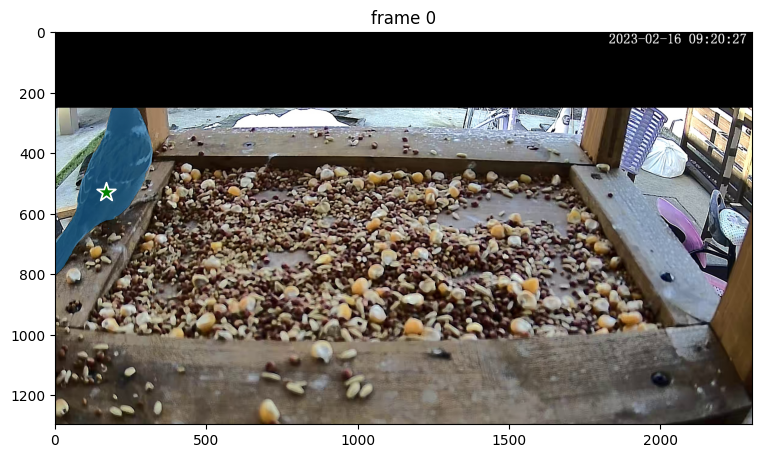

In [ ]:
# 最初のフレームを matplotlib で表示する
plt.figure(figsize=(9, 6))
plt.title(f"frame {0}")
plt.imshow(Image.open(os.path.join(video_dir, "00000.jpg")))
show_points(points, labels, plt.gca())
show_mask((video_segments[0][0] > 0.0), plt.gca(), obj_id=0)
plt.show()

In [ ]:
!zip -r yolo_results.zip yolo_results/

  adding: yolo_results/ (stored 0%)
  adding: yolo_results/00030.jpg (deflated 4%)
  adding: yolo_results/00049.jpg (deflated 4%)
  adding: yolo_results/00052.jpg (deflated 4%)
  adding: yolo_results/00060.jpg (deflated 4%)
  adding: yolo_results/00003.jpg (deflated 4%)
  adding: yolo_results/00065.jpg (deflated 4%)
  adding: yolo_results/00050.jpg (deflated 4%)
  adding: yolo_results/00055.jpg (deflated 4%)
  adding: yolo_results/00089.jpg (deflated 4%)
  adding: yolo_results/00096.jpg (deflated 4%)
  adding: yolo_results/00025.jpg (deflated 4%)
  adding: yolo_results/00088.jpg (deflated 4%)
  adding: yolo_results/00001.jpg (deflated 4%)
  adding: yolo_results/00021.jpg (deflated 4%)
  adding: yolo_results/00036.jpg (deflated 4%)
  adding: yolo_results/00077.jpg (deflated 4%)
  adding: yolo_results/00070.jpg (deflated 4%)
  adding: yolo_results/00056.jpg (deflated 4%)
  adding: yolo_results/00064.jpg (deflated 4%)
  adding: yolo_results/00020.jpg (deflated 4%)
  adding: yolo_results/0

# Task
Create a function `add_obj_if_not_overlapping` that takes the current frame index, a list of bounding boxes from Faster R-CNN, the SAM2 predictor, the current SAM2 inference state, and the segmentation results from the previous frame as input. This function should check if each bounding box from Faster R-CNN overlaps with the segmentation results from the previous frame. If a bounding box does not overlap, calculate its center point and use it as a positive point to call `predictor.add_new_points_or_box` to add a new object. The function should return the updated SAM2 inference state.

## 関数の定義

### Subtask:
`add_obj_if_not_overlapping` という新しい関数を定義します。この関数は、現在のフレームインデックス、Faster R-CNNによって検出されたバウンディングボックスのリスト、SAM2の予測器、現在のSAM2の推論状態、および前のフレームのセグメンテーション結果を引数として取ります。


**Reasoning**:
Define the function `add_obj_if_not_overlapping` with the specified arguments and include a placeholder and return statement.



In [ ]:
def add_obj_if_not_overlapping(current_frame_idx, faster_rcnn_boxes, predictor, inference_state, previous_segments):
    """
    Add new objects to the SAM2 inference state based on Faster R-CNN detections
    that do not overlap with previous segmentation results.

    Args:
        current_frame_idx (int): The index of the current frame.
        faster_rcnn_boxes (list): A list of bounding boxes from Faster R-CNN.
        predictor: The SAM2 video predictor object.
        inference_state (dict): The current SAM2 inference state.
        previous_segments (dict): Segmentation results from the previous frame.

    Returns:
        dict: The updated SAM2 inference state.
    """
    # Placeholder for the logic to be implemented later
    pass

    return inference_state

## 重複の確認

### Subtask:
関数内で、Faster R-CNNによって検出された各バウンディングボックスに対して、前のフレームのセグメンテーション結果と重複しているかどうかを確認します。重複の確認には、バウンディングボックスとマスクのIoU（Intersection over Union）を計算し、しきい値と比較する方法などが考えられます。


**Reasoning**:
Implement the logic within the `add_obj_if_not_overlapping` function to iterate through Faster R-CNN bounding boxes, calculate IoU with previous frame segments, and identify non-overlapping boxes as instructed in the subtask.



In [ ]:
def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1 (list): [x_min, y_min, x_max, y_max]
        box2 (list): [x_min, y_min, x_max, y_max]

    Returns:
        float: The IoU value.
    """
    # Determine the (x, y)-coordinates of the intersection rectangle
    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])

    # Compute the area of intersection rectangle
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # Compute the area of both the prediction and ground-truth rectangles
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou

def add_obj_if_not_overlapping(current_frame_idx, faster_rcnn_boxes, predictor, inference_state, previous_segments):
    """
    Add new objects to the SAM2 inference state based on Faster R-CNN detections
    that do not overlap with previous segmentation results.

    Args:
        current_frame_idx (int): The index of the current frame.
        faster_rcnn_boxes (list): A list of bounding boxes from Faster R-CNN.
        predictor: The SAM2 video predictor object.
        inference_state (dict): The current SAM2 inference state.
        previous_segments (dict): Segmentation results from the previous frame.

    Returns:
        dict: The updated SAM2 inference state.
    """
    non_overlapping_boxes = []
    iou_threshold = 0.5  # Define IoU threshold

    for rcnn_box in faster_rcnn_boxes:
        is_overlapping = False
        if previous_segments:
            for obj_id, mask in previous_segments.items():
                # Convert mask to bounding box for IoU calculation
                # Find the coordinates of the true values in the mask
                coords = np.where(mask)
                if coords[0].size > 0:
                    y_min_mask, y_max_mask = np.min(coords[0]), np.max(coords[0])
                    x_min_mask, x_max_mask = np.min(coords[1]), np.max(coords[1])
                    mask_box = [x_min_mask, y_min_mask, x_max_mask, y_max_mask]

                    iou = calculate_iou(rcnn_box, mask_box)
                    if iou > iou_threshold:
                        is_overlapping = True
                        break  # Found an overlapping segment, move to the next R-CNN box

        if not is_overlapping:
            non_overlapping_boxes.append(rcnn_box)
            # Placeholder for adding new object with predictor.add_new_points_or_box
            # For now, just store the non-overlapping boxes

    print(f"Found {len(non_overlapping_boxes)} non-overlapping boxes in frame {current_frame_idx}.")

    return inference_state

## オブジェクトの追加

### Subtask:
重複していないバウンディングボックスが見つかった場合、そのバウンディングボックスの中心点を計算し、その点をPositiveポイントとして使用して`predictor.add_new_points_or_box`を呼び出し、新しいオブジェクトとして追加します。


**Reasoning**:
Implement the logic to add new objects using the center point of non-overlapping bounding boxes and update the inference state.



In [ ]:
def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1 (list): [x_min, y_min, x_max, y_max]
        box2 (list): [x_min, y_min, x_max, y_max]

    Returns:
        float: The IoU value.
    """
    # Determine the (x, y)-coordinates of the intersection rectangle
    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])

    # Compute the area of intersection rectangle
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # Compute the area of both the prediction and ground-truth rectangles
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou

def add_obj_if_not_overlapping(current_frame_idx, faster_rcnn_boxes, predictor, inference_state, current_segments):
    """
    Add new objects to the SAM2 inference state based on Faster R-CNN detections
    that do not overlap with previous segmentation results.

    Args:
        current_frame_idx (int): The index of the current frame.
        faster_rcnn_boxes (list): A list of bounding boxes from Faster R-CNN.
        predictor: The SAM2 video predictor object.
        inference_state (dict): The current SAM2 inference state.
        current_segments (dict): Segmentation results from the previous frame.

    Returns:
        dict: The updated SAM2 inference state.
    """
    iou_threshold = 0.5  # Define IoU threshold
    current_obj_ids = list(inference_state['obj_ids'])
    next_obj_id = max(current_obj_ids) + 1 if current_obj_ids else 0

    for rcnn_box in faster_rcnn_boxes:
        is_overlapping = False
        if current_segments:
            for obj_id, mask in current_segments.items():
                # Convert mask to bounding box for IoU calculation
                # Find the coordinates of the true values in the mask
                coords = np.where(mask)
                if coords[0].size > 0:
                    y_min_mask, y_max_mask = np.min(coords[0]), np.max(coords[0])
                    x_min_mask, x_max_mask = np.min(coords[1]), np.max(coords[1])
                    mask_box = [x_min_mask, y_min_mask, x_max_mask, y_max_mask]

                    iou = calculate_iou(rcnn_box, mask_box)
                    if iou > iou_threshold:
                        is_overlapping = True
                        break  # Found an overlapping segment, move to the next R-CNN box

        if not is_overlapping:
            # Calculate the center point of the non-overlapping box
            center_x = (rcnn_box[0] + rcnn_box[2]) / 2.0
            center_y = (rcnn_box[1] + rcnn_box[3]) / 2.0
            points = np.array([[center_x, center_y]], dtype=np.float32)
            labels = np.array([1], np.int32)

            # Add the new object using the center point
            _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                inference_state=inference_state,
                frame_idx=current_frame_idx,
                obj_id=next_obj_id,
                points=points,
                labels=labels,
            )
            # Update the inference state with the result of adding the new object
            inference_state = predictor.inference_state # Assuming add_new_points_or_box updates the internal state or returns the updated state

            # Increment the next object ID
            next_obj_id += 1


    return inference_state

## 関数の使用

### Subtask:
この関数をビデオの各フレームに対して呼び出し、新しいオブジェクトを動画全体で追跡できるようにします。


**Reasoning**:
Iterate through each frame of the video, call the `add_obj_if_not_overlapping` function for each frame, propagate the segmentation results to the next frame, and store the segmentation results for the current frame to be used as `previous_segments` for the next frame.

